#Introduction

In this notebook we used the VGG16 network (by performing transfer learning), and fine tuning. We have done sone **modification on the dataset**:
*   We split the dataset with our script in:
    *   $75$% training set
    *   $15$% validation set
    *   $10$% test set
*   We balanced the dataset with the script made by us. We set $1100$ as threshold for the training set, while $500$ for the validation set. We did not change the test set.

**Augmentation**:

*   We applied data augmentation, in order to avoid overfitting due to some classes which had really few samples in them, like the Raspberry one. This helped also to "fill" a little bit the gap due to the difference of our sets and the test set on the server.

Moreover, here has been removed the last layer of dropout.

**Patience** was set to $10$, and **Learning Rate** was set to standard value in transfer learning, and to $1e-4$ in fine tuning.

With this notebook we got a score of $90,75$%

#Mounting Drive

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Checking which GPU I am running on

In [ ]:
!nvidia-smi

# Imports

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.0 MB/s 


In [ ]:
%ls

sample_data/


# Loading Data & folder exploration

Extracting the zipped archive into the folder in which I am when I start the notebook (/content). We did this, because by extracting the zipped archive in the local folder of the runtime, speeds up a lot the first epoch in google Colab, and make its duration as shord as the following ones. This allowed us to save a lot of GPU time.

In [ ]:
#Extracting the zipped archive into the folder in which I am 

!unzip ../gdrive/MyDrive/AN2DL/leaves_overUnder_sampled_more.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: leaves_overUnder_sampled_more/val/Pepper/192_101_33824.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/193_170_12_11477.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/194_11798.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/195_99_68_33693.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/196_134_11546.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/197_135_20_33659.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/198_12012.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/199_3_33883.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/200_56_11855.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/201_39_33741.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/202_33739.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/203_33842.jpg  
  inflating: leaves_overUnder_sampled_more/val/Pepper/204_177_11735.jpg  


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

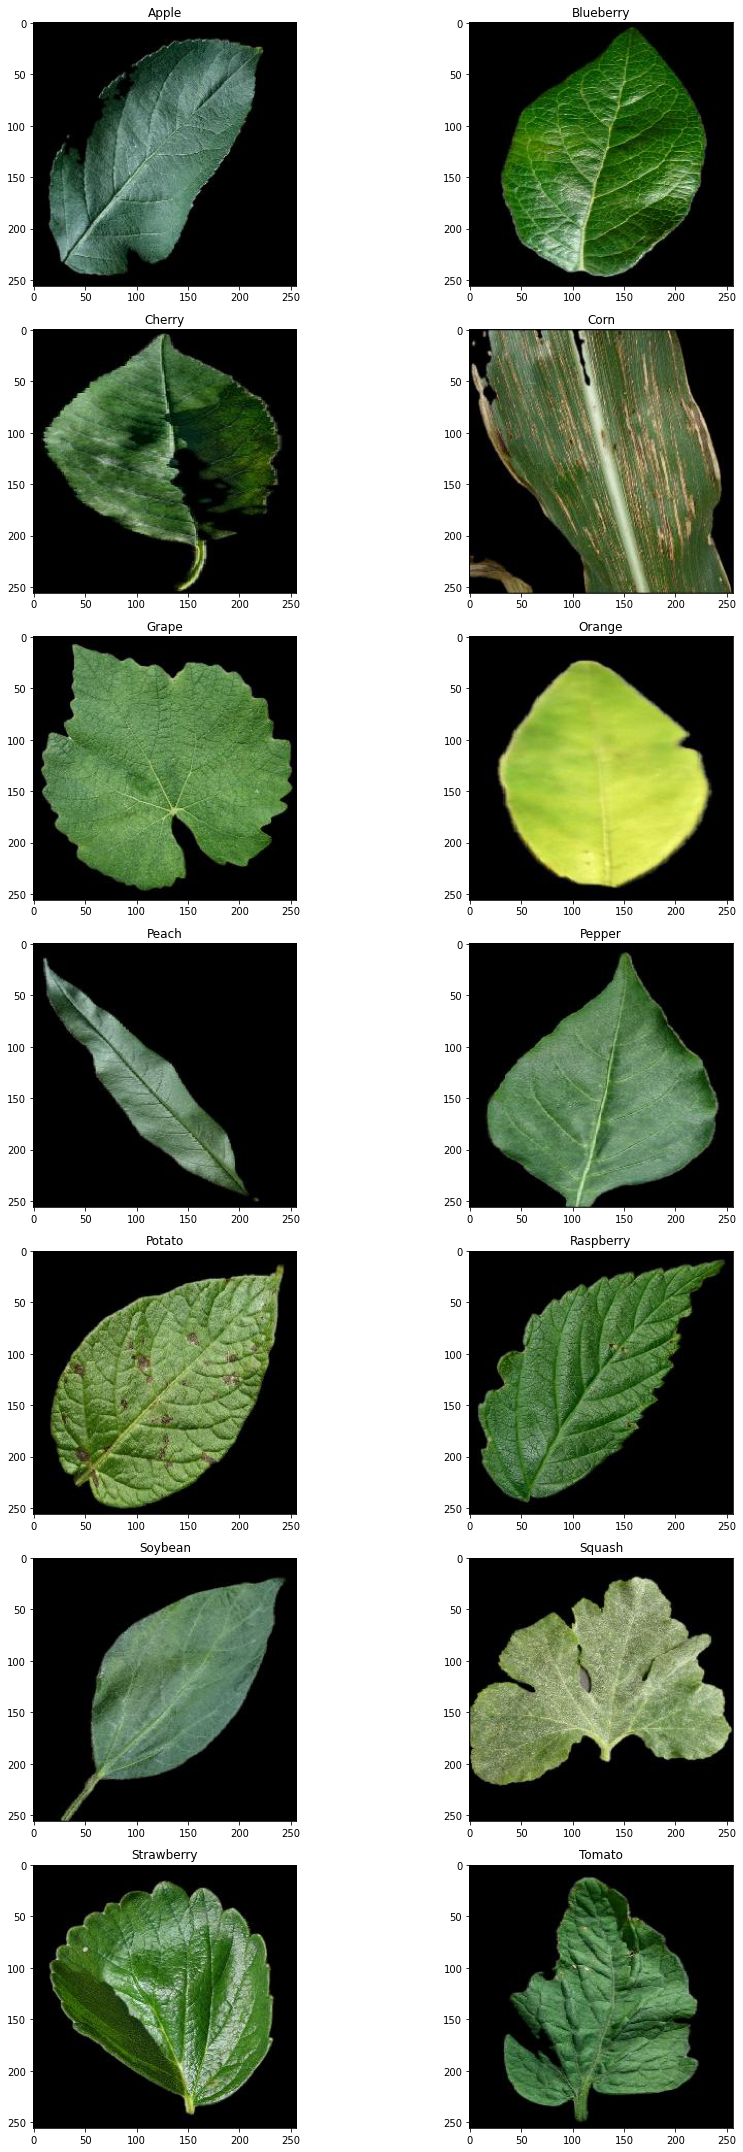

In [ ]:
dataset_dir = 'leaves_overUnder_sampled_more' #splitted like 75% train, 15%val, 10% test. Then oversampled/undersampled classes in order to reach 1100 imgs for training, and 500 for validation, forall classes

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


In [ ]:
# Inspect dataset structure on disk
print("Depth 0 leaves_overUnder_sampled_more")
print("-------")
!ls leaves_overUnder_sampled_more
print()
print("Depth 1 (e.g., leaves_overUnder_sampled_more/training)")
print("------------------------")
!ls leaves_overUnder_sampled_more/train
print()
print("Depth 2 (e.g., leaves_overUnder_sampled_more/train/Blueberry)")
print("----------------------------")
!ls leaves_overUnder_sampled_more/train/Blueberry

Depth 0 leaves_overUnder_sampled_more
-------
test  train  val

Depth 1 (e.g., leaves_overUnder_sampled_more/training)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_overUnder_sampled_more/train/Blueberry)
----------------------------
0_01792.jpg	  113_67_02058.jpg	       444_324_69_02096.jpg
01647.jpg	  114_02168.jpg		       445_171_123_115_01793.jpg
01649.jpg	  115_01793.jpg		       446_01837.jpg
01650.jpg	  116_02091.jpg		       447_189_01722.jpg
01652.jpg	  117_01845.jpg		       448_326_02185.jpg
01653.jpg	  118_01969.jpg		       449_02219.jpg
01654.jpg	  119_01831.jpg		       450_01663.jpg
01655.jpg	  120_01682.jpg		       45_02154.jpg
01656.jpg	  12_02037.jpg		       451_83_01933.jpg
01657.jpg	  121_50_01859.jpg	       452_156_126_01680.jpg
01658.jpg	  122_02160.jpg		       453_01781.jpg
01659.jpg	  123_115_01793.jpg	       454_95_01832.jpg
01663.jpg	  12

Text(0.5, 1.0, 'Number of training images per category:')

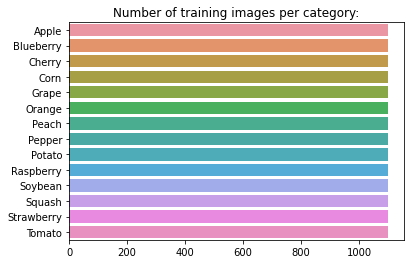

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

# Show Example Image & Augmentation

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='nearest',
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255.
                                        ) 
aug_valid_data_gen = ImageDataGenerator(#rescale=1/255.,  --- N.B. --- While trying to increase performances, we tried to perform data augmentation also here, because in some classes, like the raspberry one, when we oversampled the validation set, it contained many copies. Doing some researches, we found online that, sometimes, in some specific applications, this helped a little bit and we wanted to try
                                        rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='nearest',
                                        cval=0,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 15400 images belonging to 14 classes.
Found 7000 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


Printing sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


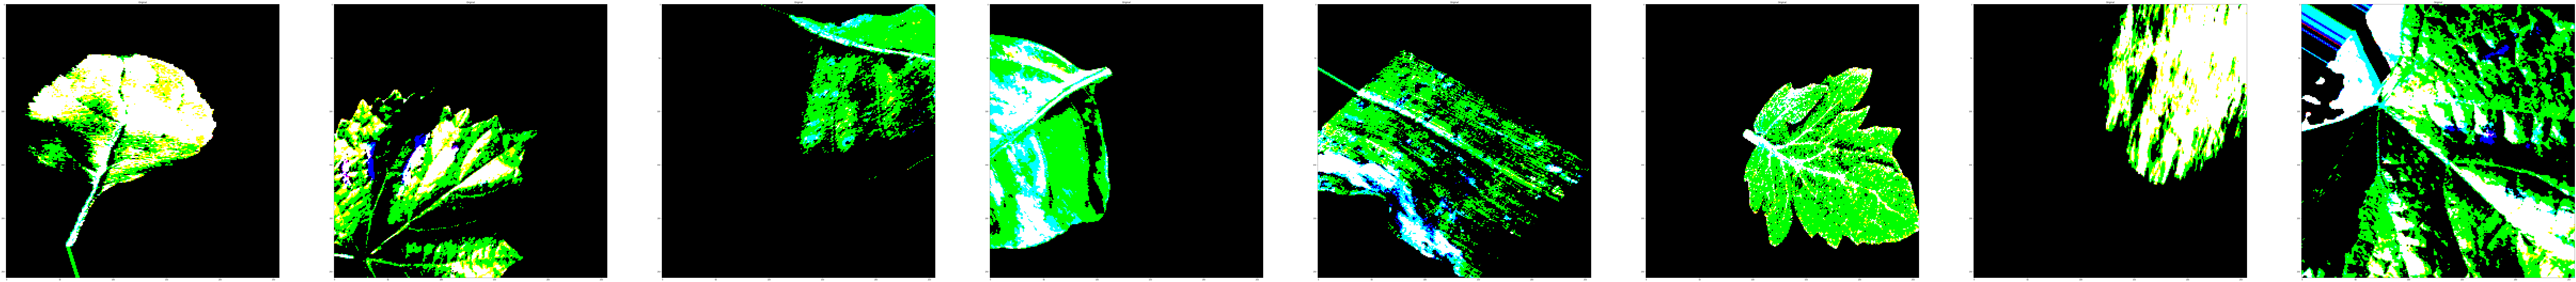

In [ ]:
image = next(aug_train_gen)[0]

fig, ax = plt.subplots(1, 8, figsize=(255, 255))
init = 0
for i in range(init, init+8):
  #print(image[i])
  ax[i-init].imshow(np.array(image[i]))
  ax[i-init].set_title('Original')

(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 14)

Categorical label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 4
Class name: Grape


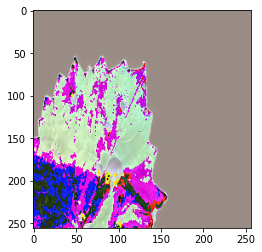

In [ ]:
 _ = get_next_batch(aug_train_gen)

# Callbacks

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/AN2DL/Checkpts/LucaA')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

# Transfer learning

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

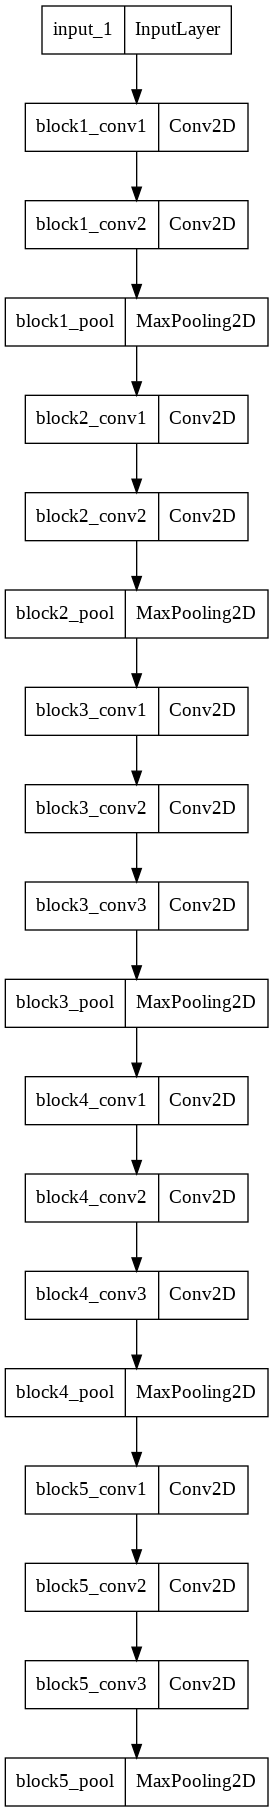

In [ ]:

# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)


### Models metadata

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
#x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 Output (Dense)              (None, 14)                3598      
                                                                 
Total params: 23,107,150
Trainable params: 8,392,462
Non-trai

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'aug_transfer_learning_balanced_more_VGG_NoLastDrpt')
#Loading checkpoints, uncomment if needed
#tl_model.load_weights('/gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_transfer_learning_balanced_more_VGG_Nov24_10-18-00/ckpts/cp.ckpt')
# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = tl_callbacks,
).history

Epoch 1/200
482/482 [==============================] - 349s 701ms/step - loss: 1.7411 - accuracy: 0.6014 - precision: 0.7232 - recall: 0.5161 - val_loss: 0.8440 - val_accuracy: 0.7420 - val_precision: 0.8120 - val_recall: 0.6893
Epoch 2/200
482/482 [==============================] - 334s 694ms/step - loss: 0.7907 - accuracy: 0.7571 - precision: 0.8255 - recall: 0.7088 - val_loss: 0.5738 - val_accuracy: 0.8206 - val_precision: 0.8690 - val_recall: 0.7771
Epoch 3/200
482/482 [==============================] - 333s 691ms/step - loss: 0.6204 - accuracy: 0.8086 - precision: 0.8585 - recall: 0.7687 - val_loss: 0.5514 - val_accuracy: 0.8217 - val_precision: 0.8742 - val_recall: 0.7803
Epoch 4/200
482/482 [==============================] - 334s 694ms/step - loss: 0.5439 - accuracy: 0.8255 - precision: 0.8722 - recall: 0.7931 - val_loss: 0.4466 - val_accuracy: 0.8620 - val_precision: 0.8910 - val_recall: 0.8351
Epoch 5/200
482/482 [==============================] - 336s 698ms/step - loss: 0.495

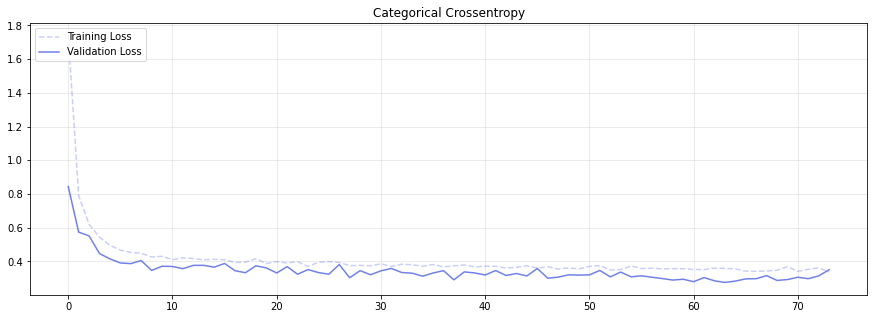

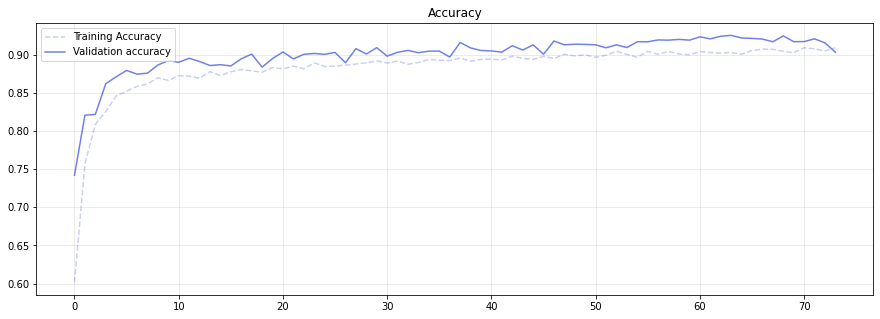

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%cd /gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
# Save the best model
tl_model.save('Models/LucaA/aug_transfer_learning_balanced_more_VGG_NoLastDrpt')

INFO:tensorflow:Assets written to: Models/LucaA/aug_transfer_learning_balanced_more_VGG_NoLastDrpt/assets


# Fine Tuning

In [ ]:
%cd /content

/content


In [ ]:
%ls

leaves_overUnder_sampled_more/  model.png  sample_data/


In [ ]:
# Re-load the model after transfer learning
tl_model = tfk.models.load_model('../gdrive/MyDrive/AN2DL/models/Models/LucaA/aug_transfer_learning_balanced_more_VGG_NoLastDrpt')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 Output (Dense)              (None, 14)                3598      
                                                                 
Total params: 23,107,150
Trainable params: 8,392,462
Non-trai

In [ ]:
# Set all VGG layers to True
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0       

In [ ]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    #batch_size = 32,
    epochs = 200,
    validation_data = aug_valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)]
).history

Epoch 1/200
482/482 [==============================] - 340s 679ms/step - loss: 0.5267 - accuracy: 0.8610 - precision_1: 0.8943 - recall_1: 0.8399 - val_loss: 0.2859 - val_accuracy: 0.9224 - val_precision_1: 0.9403 - val_recall_1: 0.9040
Epoch 2/200
482/482 [==============================] - 322s 668ms/step - loss: 0.2959 - accuracy: 0.9203 - precision_1: 0.9401 - recall_1: 0.9054 - val_loss: 0.2747 - val_accuracy: 0.9226 - val_precision_1: 0.9390 - val_recall_1: 0.9107
Epoch 3/200
482/482 [==============================] - 320s 665ms/step - loss: 0.2073 - accuracy: 0.9425 - precision_1: 0.9552 - recall_1: 0.9330 - val_loss: 0.1826 - val_accuracy: 0.9487 - val_precision_1: 0.9589 - val_recall_1: 0.9407
Epoch 4/200
482/482 [==============================] - 321s 666ms/step - loss: 0.1833 - accuracy: 0.9483 - precision_1: 0.9592 - recall_1: 0.9397 - val_loss: 0.1984 - val_accuracy: 0.9477 - val_precision_1: 0.9566 - val_recall_1: 0.9439
Epoch 5/200
482/482 [==============================]

In [ ]:
%cd ../gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
#Save the best model
tl_model.save('Models/LucaA/aug_transfer_learning_balanced_more_VGG_NoLastDrpt_tuned_correctly')

INFO:tensorflow:Assets written to: Models/LucaA/aug_transfer_learning_balanced_more_VGG_NoLastDrpt_tuned_correctly/assets


In [ ]:
%cd /content

/content


In [ ]:
model_to_be_tested = tfk.models.load_model("../gdrive/MyDrive/AN2DL/models/Models/LucaA/aug_transfer_learning_balanced_more_VGG_NoLastDrpt_tuned_correctly")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)


56/56 [==============================] - 9s 162ms/step - loss: 0.0514 - accuracy: 0.9899 - precision_1: 0.9910 - recall_1: 0.9894


#Confusion Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Accuracy: 0.9899
Precision: 0.9862
Recall: 0.9938
F1: 0.9899


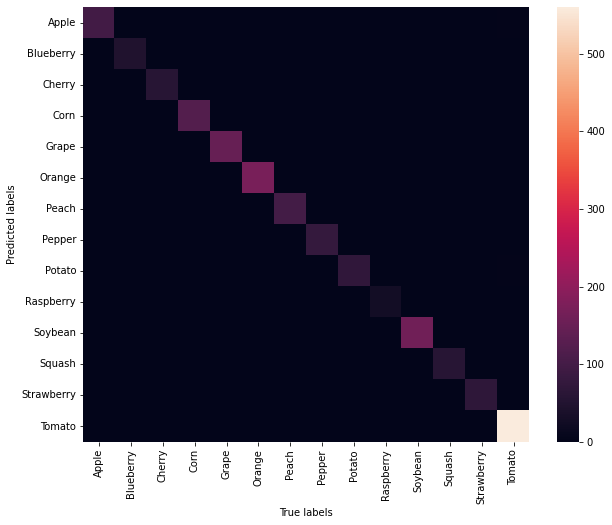

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model_to_be_tested.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()